<a href="https://colab.research.google.com/github/sepehr21ar/Deep_Learning_Project/blob/main/dog_breeds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# !mkdir ~/.kaggle
# !mv kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!kaggle competitions download -c dog-breed-identification


 97% 671M/691M [00:12<00:00, 56.5MB/s]
100% 691M/691M [00:12<00:00, 59.4MB/s]


In [5]:
!unzip -q dog-breed-identification.zip

In [6]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [7]:

df = pd.read_csv('labels.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [8]:
print(len(df))
print(df['breed'].nunique())
print(df['breed'].unique())

10222
120
['boston_bull' 'dingo' 'pekinese' 'bluetick' 'golden_retriever'
 'bedlington_terrier' 'borzoi' 'basenji' 'scottish_deerhound'
 'shetland_sheepdog' 'walker_hound' 'maltese_dog' 'norfolk_terrier'
 'african_hunting_dog' 'wire-haired_fox_terrier' 'redbone'
 'lakeland_terrier' 'boxer' 'doberman' 'otterhound' 'standard_schnauzer'
 'irish_water_spaniel' 'black-and-tan_coonhound' 'cairn' 'affenpinscher'
 'labrador_retriever' 'ibizan_hound' 'english_setter' 'weimaraner'
 'giant_schnauzer' 'groenendael' 'dhole' 'toy_poodle' 'border_terrier'
 'tibetan_terrier' 'norwegian_elkhound' 'shih-tzu' 'irish_terrier'
 'kuvasz' 'german_shepherd' 'greater_swiss_mountain_dog' 'basset'
 'australian_terrier' 'schipperke' 'rhodesian_ridgeback' 'irish_setter'
 'appenzeller' 'bloodhound' 'samoyed' 'miniature_schnauzer'
 'brittany_spaniel' 'kelpie' 'papillon' 'border_collie' 'entlebucher'
 'collie' 'malamute' 'welsh_springer_spaniel' 'chihuahua' 'saluki' 'pug'
 'malinois' 'komondor' 'airedale' 'leonberg' 

In [9]:
df["breed"].value_counts()


,count
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114
...,...
golden_retriever,67
komondor,67
brabancon_griffon,67


In [10]:
# Path to your image directory
data_directory = 'train'

# Add a new column with the full path to the image
df['path'] = df['id'].apply(lambda x: f'{data_directory}/{x}.jpg')

# Encode labels to integers
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['breed'])

df.head()

,id,breed,path,label
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,train/000bec180eb18c7604dcecc8fe0dba07.jpg,19
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,train/001513dfcb2ffafc82cccf4d8bbaba97.jpg,37
2,001cdf01b096e06d78e9e5112d419397,pekinese,train/001cdf01b096e06d78e9e5112d419397.jpg,85
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,train/00214f311d5d2247d5dfe4fe24b2303d.jpg,15
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,train/0021f9ceb3235effd7fcde7f7538ed62.jpg,49


In [11]:
train_df, validation_df = train_test_split(df, test_size=0.2, random_state=42)


In [15]:
def load_and_preprocess_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (160, 160))  # Adjust the target size according to your model requirements
    return img, label


In [16]:
# Create TensorFlow Datasets for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['path'].values, train_df['label'].values))
train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=len(train_df)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

validation_dataset = tf.data.Dataset.from_tensor_slices((validation_df['path'].values, validation_df['label'].values))
validation_dataset = validation_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.batch(32).prefetch(tf.data.experimental.AUTOTUNE)

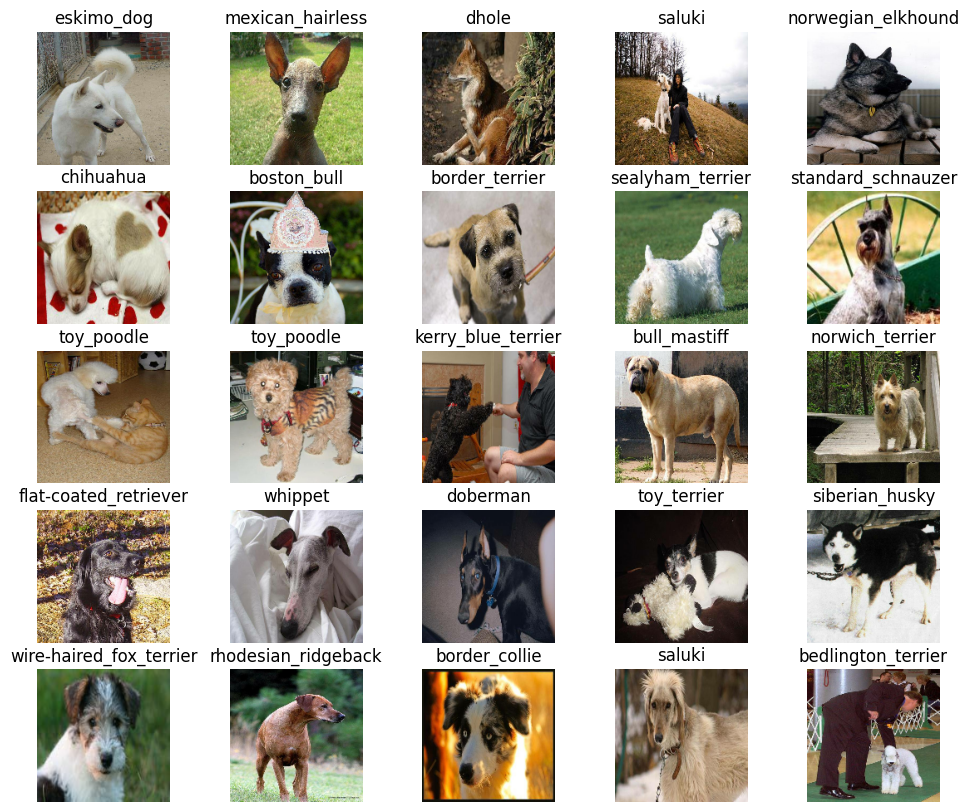

In [14]:
 # Function to show a batch of images with labels as titles
def show_batch(dataset, label_encoder, num_samples=25):
    plt.figure(figsize=(12, 10))
    for images, labels in dataset.take(1):
        for i in range(min(num_samples, len(labels))):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy()/255)
            plt.title(label_encoder.inverse_transform([labels[i].numpy()])[0])
            plt.axis("off")

# Show a batch of images from the training dataset
show_batch(train_dataset, label_encoder)
plt.show()

In [17]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [18]:
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(PreprocessLayer, self).__init__()

    def call(self, inputs):
        return tf.keras.applications.densenet.preprocess_input(inputs)

In [19]:
base_model = tf.keras.applications.DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(160, 160, 3)
)

# Freeze the base model
base_model.trainable = False
model = tf.keras.Sequential([
    tf.keras.Input(shape=(160, 160, 3)),
    PreprocessLayer(),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')
])

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [20]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'sparse_top_k_categorical_accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

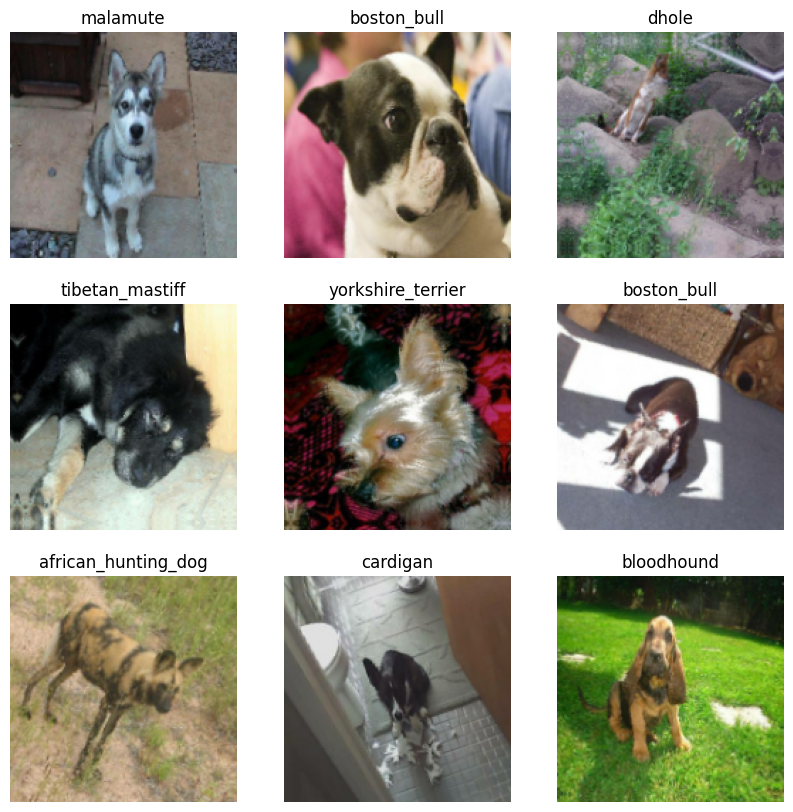

In [21]:
def show_augmented_images(dataset, augmentation_layer, label_encoder, num_samples=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        augmented_images = augmentation_layer(images)
        for i in range(min(num_samples, len(labels))):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[i].numpy() / 255.0)
            plt.title(label_encoder.inverse_transform([labels[i].numpy()])[0])
            plt.axis("off")
    plt.show()

show_augmented_images(train_dataset, data_augmentation, label_encoder)

In [22]:
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 65s 134ms/step - accuracy: 0.1128 - loss: 6.4014 - sparse_top_k_categorical_accuracy: 0.2737 - val_accuracy: 0.5540 - val_loss: 2.4496 - val_sparse_top_k_categorical_accuracy: 0.8826 - learning_rate: 0.0010
Epoch 2/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 36s 107ms/step - accuracy: 0.4234 - loss: 2.9071 - sparse_top_k_categorical_accuracy: 0.7574 - val_accuracy: 0.6440 - val_loss: 1.8329 - val_sparse_top_k_categorical_accuracy: 0.9208 - learning_rate: 0.0010
Epoch 3/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.5012 - loss: 2.3322 - sparse_top_k_categorical_accuracy: 0.8265 - val_accuracy: 0.6733 - val_loss: 1.6026 - val_sparse_top_k_categorical_accuracy: 0.9325 - learning_rate: 0.0010
Epoch 4/20
256/256 ━━━━━━━━━━━━━━━━━━━━ 35s 105ms/step - accuracy: 0.5381 - loss: 2.0795 - sparse_top_k_categorical_accuracy: 0.8540 - val_accuracy: 0.6836 - val_loss: 1.5050 - val_sparse_top_k_categorical_accuracy: 0.9330 - learning_rate: 0.0010
Epoch 5/20
2

In [23]:
base_model.trainable = True
for layer in base_model.layers[:int(0.8 * len(base_model.layers))]:
    layer.trainable = False
optimizer_fine = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer_fine,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', 'sparse_top_k_categorical_accuracy'])

history_fine = model.fit(
train_dataset,
epochs=10,
validation_data=validation_dataset,
callbacks=[early_stopping, reduce_lr]
)

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 78s 155ms/step - accuracy: 0.6330 - loss: 1.7258 - sparse_top_k_categorical_accuracy: 0.9024 - val_accuracy: 0.7267 - val_loss: 1.2566 - val_sparse_top_k_categorical_accuracy: 0.9462 - learning_rate: 1.0000e-05
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 48s 147ms/step - accuracy: 0.6415 - loss: 1.6237 - sparse_top_k_categorical_accuracy: 0.9115 - val_accuracy: 0.7286 - val_loss: 1.2458 - val_sparse_top_k_categorical_accuracy: 0.9447 - learning_rate: 1.0000e-05
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 42s 126ms/step - accuracy: 0.6396 - loss: 1.5931 - sparse_top_k_categorical_accuracy: 0.9169 - val_accuracy: 0.7286 - val_loss: 1.2325 - val_sparse_top_k_categorical_accuracy: 0.9438 - learning_rate: 1.0000e-05
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 87s 148ms/step - accuracy: 0.6550 - loss: 1.5529 - sparse_top_k_categorical_accuracy: 0.9131 - val_accuracy: 0.7315 - val_loss: 1.2223 - val_sparse_top_k_categorical_accuracy: 0.9438 - learning_rate: 1.0000e

In [24]:
len(base_model.layers)

427

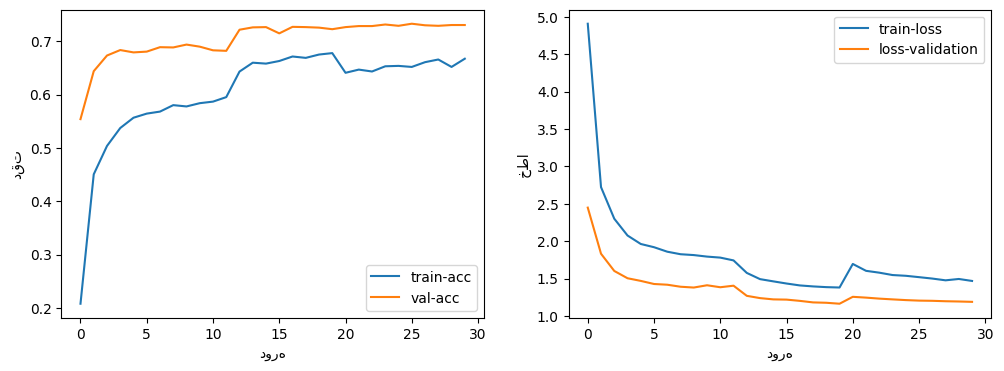

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ preprocess_layer                │ (None, 160, 160, 3)    │             0 │
│ (PreprocessLayer)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 5, 5, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 120)            │        30,840 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,358,122 (43.33 MB)

 Trainable params: 2,013,688 (7.68 MB)

 Non-trainable params: 5,317,056 (20.28 MB)

 Optimizer params: 4,027,378 (15.36 MB)

In [25]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='train-acc')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='val-acc')
plt.xlabel('دوره')
plt.ylabel('دقت')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='train-loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='loss-validation')
plt.xlabel('دوره')
plt.ylabel('خطا')
plt.legend()
plt.show()

# نمایش خلاصه مدل
model.summary()

path of testing image: train/3b8b463b6d1b40bde998896767e6c985.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


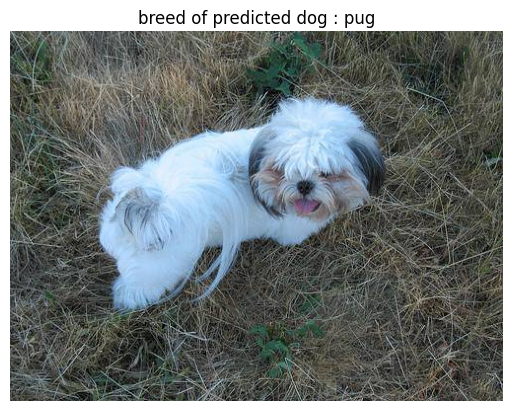

In [28]:
def predict_image(img_path, model, label_encoder):
    """پیش‌بینی نژاد سگ از روی مسیر عکس"""
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (160, 160))
    img = tf.keras.applications.densenet.preprocess_input(img)
    img = tf.expand_dims(img, 0)  # تبدیل به batch با یک نمونه

    predictions = model.predict(img)
    predicted_label = tf.argmax(predictions[0]).numpy()
    predicted_breed = label_encoder.inverse_transform([predicted_label])[0]

    plt.imshow(plt.imread(img_path))
    plt.title(f'breed of predicted dog : {predicted_breed}')
    plt.axis("off")
    plt.show()

# انتخاب یک عکس تصادفی از داده‌های تست
sample_image_path = validation_df.sample(1)['path'].values[0]
print(f"path of testing image: {sample_image_path}")

predict_image(sample_image_path, model, label_encoder)
